In [2]:
# import nltk
# import subprocess

# # Download and unzip wordnet
# try:
#     nltk.data.find('wordnet.zip')
# except:
#     nltk.download('wordnet', download_dir='/kaggle/working/')
#     command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
#     subprocess.run(command.split())
#     nltk.data.path.append('/kaggle/working/')

# # Now you can import the NLTK resources as usual
# from nltk.corpus import wordnet

In [3]:
# import nltk
# # nltk.download('stopwords')
# # nltk.download('wordnet')
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU found")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Sorry, no GPU found")

GPU found


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout,SpatialDropout1D,Bidirectional,LSTM
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D,GlobalMaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models, layers
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
from string import punctuation
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
import matplotlib.pyplot as plt
from nltk.tag import pos_tag

# **Retrieving Dataset**

### Training Dataframe

In [5]:
# https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
df = pd.read_csv('twitter_training.csv')
df.head(3)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


Testing Dataframe

In [6]:
df_validation = pd.read_csv('twitter_validation.csv')
df.head(3)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


There is an issue with the dataset, there are no column names. So, we will add the column names manually.

In [7]:
print(df.shape)
print(df_validation.shape)

(74681, 4)
(999, 4)


In [8]:
# Add column names (Tweet_id, entity, sentiment, tweet)
df.columns = ['id', 'entity', 'sentiment', 'tweet']
df_validation.columns = ['id', 'entity', 'sentiment', 'tweet']
df.head(3)

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


# **Data Preprocessing**

### Perform missing values/duplicated data checking and cleaning

In [9]:
print(df.isna().sum())
print("Duplicated Data:",df.duplicated().sum())

id             0
entity         0
sentiment      0
tweet        686
dtype: int64
Duplicated Data: 2700


In [10]:
df = df.dropna()
df = df.drop_duplicates()
print(df.isna().sum())
print("Duplicated Data:",df.duplicated().sum())

id           0
entity       0
sentiment    0
tweet        0
dtype: int64
Duplicated Data: 0


In [11]:
# Mapping
df['sentiment'].value_counts()

sentiment
Negative      21698
Positive      19712
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

The dataset is considered balanced

# **Text Preprocessing**

In [12]:
def preprocessing(tweet):
    # Lowercase
    tweet = tweet.lower()
    # URL
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    # Emoji
    tweet = re.sub(r'[^\x00-\x7F]+', ' ', tweet)
    # Punctuation
    tweet = re.sub(r'[^a-zA-Z0-9\s]', ' ', tweet)
    # Numbers
    tweet = re.sub(r'\d+', ' ', tweet)
    # Excess whitespaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    # Word Normalization
    tweet = re.sub(r"won\'t", "would not", tweet)
    tweet = re.sub(r"im", "i am", tweet)
    tweet = re.sub(r"Im", "i am", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"don\'t", "do not", tweet)
    tweet = re.sub(r"shouldn\'t", "should not", tweet)
    tweet = re.sub(r"needn\'t", "need not", tweet)
    tweet = re.sub(r"hasn\'t", "has not", tweet)
    tweet = re.sub(r"haven\'t", "have not", tweet)
    tweet = re.sub(r"weren\'t", "were not", tweet)
    tweet = re.sub(r"mightn\'t", "might not", tweet)
    tweet = re.sub(r"didn\'t", "did not", tweet)
    tweet = re.sub(r"wasn\'t", "was not", tweet)
    tweet = re.sub(r"ain\'t", "am not", tweet)
    tweet = re.sub(r"aren\'t", "are not", tweet)
    tweet = re.sub(r"\'bout", "about", tweet)
    tweet = re.sub(r"\'til", "until", tweet)
    tweet = re.sub(r"\'till", "until", tweet)
    tweet = re.sub(r"\'cause", "because", tweet)
    tweet = re.sub(r"\'em", "them", tweet)
    tweet = re.sub(r"\'n", "and", tweet)
    tweet = re.sub(r"\'d've", "would have", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    tweet = re.sub(r'unk', ' ', tweet)
    return tweet

df['tweet'] = df['tweet'].apply(preprocessing)
df_validation['tweet'] = df_validation['tweet'].apply(preprocessing)

In [13]:
df.head(5)

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,i am coming to the borders and i will kill you...
1,2401,Borderlands,Positive,i am getting on borderlands and i will kill yo...
2,2401,Borderlands,Positive,i am coming on borderlands and i will murder y...
3,2401,Borderlands,Positive,i am getting on borderlands and i will murder ...
4,2401,Borderlands,Positive,i am getting into borderlands and i can murder...


### Lemmatization

In [14]:
wnl = WordNetLemmatizer()
all_stopwords = set(stopwords.words('english'))
all_stopwords = [w for w in all_stopwords if w not in ['no','not']]


def lemmatizing(tweet):
    words = tweet.split()
    lemmatized_words = [wnl.lemmatize(word) for word in words if word not in all_stopwords]
    return ' '.join(lemmatized_words)

In [15]:
df['tweet'] = df['tweet'].apply(lemmatizing)
df_validation['tweet'] = df_validation['tweet'].apply(lemmatizing)

In [16]:
df.head(5)

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,coming border kill
1,2401,Borderlands,Positive,getting borderland kill
2,2401,Borderlands,Positive,coming borderland murder
3,2401,Borderlands,Positive,getting borderland murder
4,2401,Borderlands,Positive,getting borderland murder


In [17]:
# Combine the lists (tweet_list, sentiment_list) into a DataFrame
df_training = df[['tweet', 'sentiment']].copy()
df_validation = df_validation[['tweet','sentiment']].copy()

Encode the sentiment

In [18]:
mappings = {
    'Negative': 0,
    'Neutral': 2,
    'Positive': 1
}

df_training = df_training[df_training['sentiment'] != 'Irrelevant']
df_validation = df_validation[df_validation['sentiment'] != 'Irrelevant']

df_training['sentiment'] = df_training['sentiment'].map(mappings)
df_validation['sentiment'] = df_validation['sentiment'].map(mappings)


In [19]:
tweet_list_train = df_training['tweet'].values
sentiment_list_train = df_training['sentiment'].values
tweet_list_val = df_validation['tweet'].values
sentiment_list_val = df_validation['sentiment'].values

### Fitting Tokenizer

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_list_train)

# Convert text data to sequences of integers
train_sequences = tokenizer.texts_to_sequences(tweet_list_train)
valid_sequences = tokenizer.texts_to_sequences(tweet_list_val)

maxlength = 100 # Maximum length of the sequences after padding

X = pad_sequences(train_sequences, maxlen=maxlength)
X_valid = pad_sequences(valid_sequences, maxlen=maxlength)

In [21]:
# Save the tokenizer file as pkl
with open('tokenizer.pkl', 'wb') as file:
    pkl.dump(tokenizer, file)

# **Model Training**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, sentiment_list_train, test_size=0.1, random_state=42)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(sentiment_list_val.shape)

(53206, 100)
(53206,)
(5912, 100)
(5912,)
(828, 100)
(828,)


In [24]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

train_labels = np.array(y_train) 
test_labels = np.array(y_test)
sentiment_list_val = np.array(sentiment_list_val)

In [25]:
X_train.shape

(53206, 100)

In [26]:
model = models.Sequential([
    Embedding(input_dim=10000, output_dim=200),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),  # BiLSTM without return_sequences, final output
    layers.Dropout(0.3), # Dropout is used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
    layers.Dense(32, activation='relu'),  # Additional Dense layer with ReLU
    layers.Dropout(0.3),  # Regular Dropout after Dense layer
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes
])

opt = Adam(learning_rate = 0.005) # 0.001 0.0025 0,005 0.01

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',  # Menggunakan sparse loss karena labelnya integer
    metrics=['accuracy']
)


2025-01-03 22:46:00.527341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-03 22:46:00.527452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-03 22:46:00.527488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-03 22:46:00.897855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-03 22:46:00.898577: I external/local_xla/xla/stream_executor

In [27]:
history = model.fit(
    X_train, train_labels,
    validation_data=(X_valid, sentiment_list_val),
    epochs=30,
    batch_size=512,
    verbose=1
)

Epoch 1/30


2025-01-03 22:46:10.324581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/kevin/anaconda3/envs/tf/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2025-01-03 22:46:11.316035: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f884812bb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-03 22:46:11.316089: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-01-03 22:46:11.349483: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735919171.552561  160313 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 [==============================] - 27s 168ms/step - loss: 0.6999 - accuracy: 0.7009 - val_loss: 0.3294 - val_accuracy: 0.8829
Epoch 2/30
104/104 [==============================] - 15s 149ms/step - loss: 0.3366 - accuracy: 0.8729 - val_loss: 0.2509 - val_accuracy: 0.9263
Epoch 3/30
104/104 [==============================] - 13s 129ms/step - loss: 0.2377 - accuracy: 0.9086 - val_loss: 0.2456 - val_accuracy: 0.9227
Epoch 4/30
104/104 [==============================] - 12s 116ms/step - loss: 0.1840 - accuracy: 0.9257 - val_loss: 0.2785 - val_accuracy: 0.9263
Epoch 5/30
104/104 [==============================] - 13s 122ms/step - loss: 0.1498 - accuracy: 0.9378 - val_loss: 0.3279 - val_accuracy: 0.9215
Epoch 6/30
104/104 [==============================] - 11s 102ms/step - loss: 0.1326 - accuracy: 0.9440 - val_loss: 0.2999 - val_accuracy: 0.9336
Epoch 7/30
104/104 [==============================] - 10s 93ms/step - loss: 0.1181 - accuracy: 0.9499 - val_loss: 0.3369 - val_accuracy: 0.93

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         336896    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [29]:
model.save('bilstm.h5')

/home/kevin/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model Evaluation

In [30]:
test_loss, test_accuracy = model.evaluate(X_test,test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.4f}%")

185/185 [==============================] - 4s 22ms/step - loss: 0.5216 - accuracy: 0.9071
Test Accuracy: 90.7138%


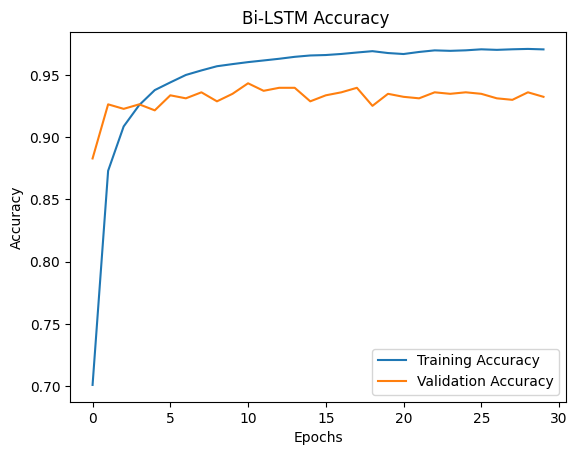

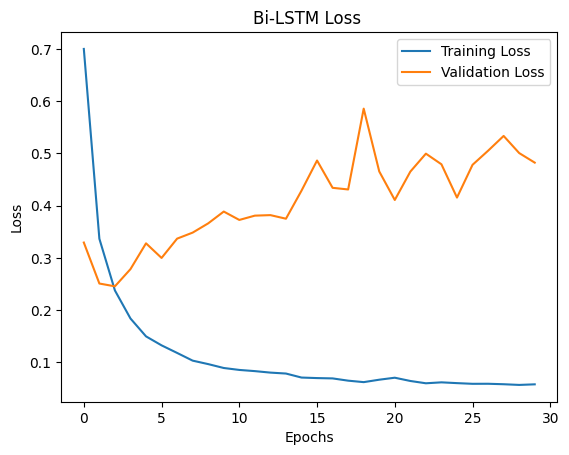

In [31]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Bi-LSTM Accuracy ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Bi-LSTM Loss ")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

##### Confusion Matrix for testing data

185/185 [==============================] - 5s 20ms/step


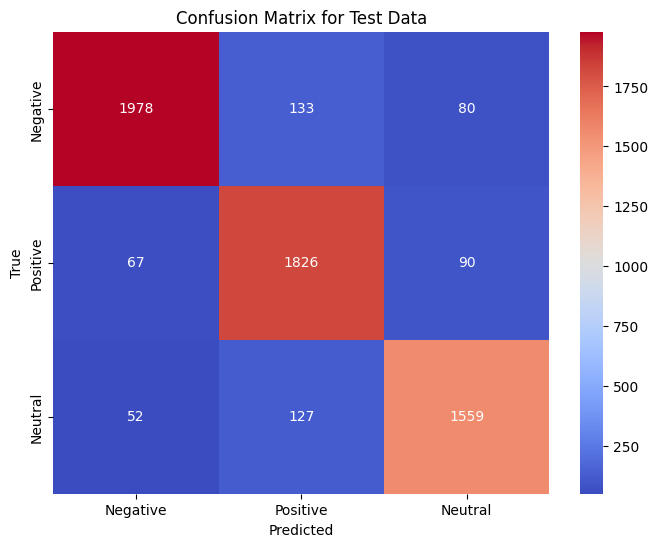

In [32]:
def prepare_labels(predictions, true_labels):
    pred_labels = predictions if len(predictions.shape) == 1 else np.argmax(predictions, axis=1)
    true_labels = true_labels if len(true_labels.shape) == 1 else np.argmax(true_labels, axis=1)
    return pred_labels, true_labels

def plot_confusion_matrix(conf_matrix, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title} Data')
    plt.show()

# Prediction and label preparation
y_pred = model.predict(X_test)
y_pred_labels, y_true_labels = prepare_labels(y_pred, test_labels)

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
class_names = ['Negative', 'Positive', 'Neutral']  # Adjust class names as needed
plot_confusion_matrix(conf_matrix, class_names, 'Test')


##### Confusion Matrix for Validation Data

26/26 [==============================] - 1s 19ms/step


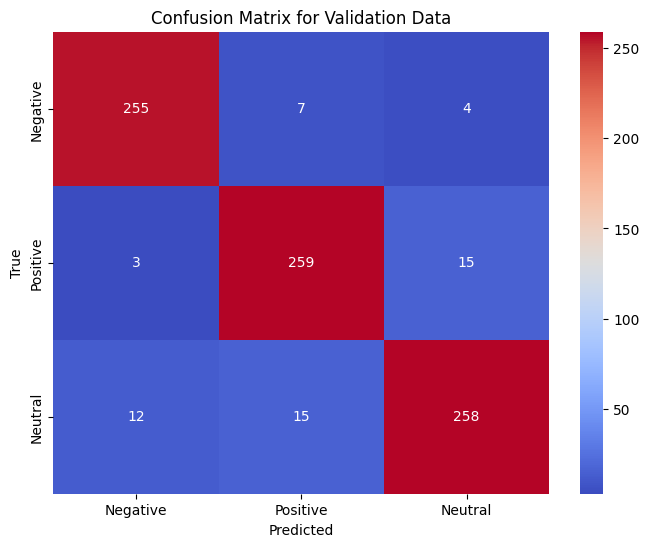

In [33]:
# Confusion matrix for validation data
y_pred_val = model.predict(X_valid)
y_pred_labels_val, y_true_labels_val = prepare_labels(y_pred_val, sentiment_list_val)

conf_matrix_val = confusion_matrix(y_true_labels_val, y_pred_labels_val)
plot_confusion_matrix(conf_matrix_val, class_names, 'Validation')
